# Milestone 3 — Pre-Processing & First Model 
MLB Game Prediction: Data Ingestion, Preprocessing, and Modeling


## Data Ingestion and Assembly 

### We fetch live game data and team statistics, merging them into a single DataFrame for analysis.

In [2]:
import warnings
import pandas as pd
import numpy as np
import requests
import re
from pathlib import Path
from pybaseball import team_batting, team_pitching, cache


warnings.filterwarnings("ignore", category=FutureWarning, module=r".*pybaseball.*")
warnings.filterwarnings("ignore", category=UserWarning, message=r"Could not infer format.*")

cache.enable()

In [3]:
# Do not run this cell, data has already been stored in csv

SEASONS = [2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024] # exclude 2020/Covid
TEAMS = ['ARI','ATL','BAL','BOS','CHC','CHW','CIN','CLE','COL','DET','HOU','KCR','LAA','LAD','MIA','MIL','MIN','NYM','NYY','OAK','PHI','PIT','SDP','SEA','SFG','STL','TBR','TEX','TOR','WSN']


TEAM_LEAGUE = {
    'ARI':'NL','ATL':'NL','BAL':'AL','BOS':'AL','CHC':'NL','CHW':'AL','CIN':'NL','CLE':'AL',
    'COL':'NL','DET':'AL','HOU':'AL','KCR':'AL','LAA':'AL','LAD':'NL','MIA':'NL','MIL':'NL',
    'MIN':'AL','NYM':'NL','NYY':'AL','OAK':'AL','PHI':'NL','PIT':'NL','SDP':'NL','SEA':'AL',
    'SFG':'NL','STL':'NL','TBR':'AL','TEX':'AL','TOR':'AL','WSN':'NL'
}
STATS_ABBR = { 'ARI':'ARI','ATL':'ATL','BAL':'BAL','BOS':'BOS','CHC':'CHC','CHW':'CWS','CIN':'CIN','CLE':'CLE', 'COL':'COL','DET':'DET','HOU':'HOU','KCR':'KC','LAA':'LAA','LAD':'LAD','MIA':'MIA','MIL':'MIL', 'MIN':'MIN','NYM':'NYM','NYY':'NYY','OAK':'OAK','PHI':'PHI','PIT':'PIT','SDP':'SD','SEA':'SEA', 'SFG':'SF','STL':'STL','TBR':'TB','TEX':'TEX','TOR':'TOR','WSN':'WSH' }
INVERSE_STATS_ABBR = {v: k for k, v in STATS_ABBR.items()}
STATIC_ABBR_TO_ID = {
    'ARI':109, 'ATL':144, 'BAL':110, 'BOS':111, 'CHC':112, 'CWS':145, 'CIN':113, 'CLE':114,
    'COL':115, 'DET':116, 'HOU':117, 'KC':118, 'LAA':108, 'LAD':119, 'MIA':146, 'MIL':158,
    'MIN':142, 'NYM':121, 'NYY':147, 'OAK':133, 'PHI':143, 'PIT':134, 'SD':135, 'SEA':136,
    'SF':137, 'STL':138, 'TB':139, 'TEX':140, 'TOR':141, 'WSH':120
}
ABBR_TO_NAME = {
    'ARI':'Arizona Diamondbacks','ATL':'Atlanta Braves','BAL':'Baltimore Orioles','BOS':'Boston Red Sox',
    'CHC':'Chicago Cubs','CHW':'Chicago White Sox','CIN':'Cincinnati Reds','CLE':'Cleveland Guardians',
    'COL':'Colorado Rockies','DET':'Detroit Tigers','HOU':'Houston Astros','KCR':'Kansas City Royals',
    'LAA':'Los Angeles Angels','LAD':'Los Angeles Dodgers','MIA':'Miami Marlins','MIL':'Milwaukee Brewers',
    'MIN':'Minnesota Twins','NYM':'New York Mets','NYY':'New York Yankees','OAK':'Oakland Athletics',
    'PHI':'Philadelphia Phillies','PIT':'Pittsburgh Pirates','SDP':'San Diego Padres','SEA':'Seattle Mariners',
    'SFG':'San Francisco Giants','STL':'St. Louis Cardinals','TBR':'Tampa Bay Rays','TEX':'Texas Rangers',
    'TOR':'Toronto Blue Jays','WSN':'Washington Nationals'
}
NAME_TO_ABBR = {v: k for k, v in ABBR_TO_NAME.items()}
ALIASES = {'WSH':'WSN','TB':'TBR','SD':'SDP','KC':'KCR','CWS':'CHW','SF':'SFG','AZ':'ARI'}

_ID_BY_ABBR = {}
_ABBR_BY_ID = {}

def _init_team_maps(season: int):
    global _ID_BY_ABBR, _ABBR_BY_ID
    if _ID_BY_ABBR: return
    api_abbr_to_id = {}
    for params in ({"sportId": 1, "season": season}, {"sportId": 1}):
        try:
            r = requests.get("https://statsapi.mlb.com/api/v1/teams", params=params, timeout=30)
            r.raise_for_status()
            teams = r.json().get("teams", [])
            api_abbr_to_id = {t.get("abbreviation"): t.get("id") for t in teams if t.get("abbreviation") and t.get("id")}
            if api_abbr_to_id: break
        except Exception: continue
    merged = dict(STATIC_ABBR_TO_ID)
    merged.update(api_abbr_to_id)
    _ABBR_BY_ID = {tid: abbr for abbr, tid in merged.items()}
    _ID_BY_ABBR = {mine: merged[api] for mine, api in STATS_ABBR.items()}

def _fetch_sched(season, team):
    _init_team_maps(season)
    tid = _ID_BY_ABBR.get(team)
    if tid is None: raise KeyError(team)
    r = requests.get("https://statsapi.mlb.com/api/v1/schedule", params={"sportId": 1, "teamId": tid, "startDate": f"03/01/{season}", "endDate": f"12/31/{season}", "gameType": "R"}, timeout=60)
    r.raise_for_status()
    data = r.json()
    games = []
    for d in data.get("dates", []):
        for g in d.get("games", []):
            tm = g.get("teams", {})
            home, away = tm.get("home", {}), tm.get("away", {})
            
            games.append({
                "game_pk": g.get("gamePk"), "game_date": d.get("date"),
                "home_id": (home.get("team") or {}).get("id"), "away_id": (away.get("team") or {}).get("id"),
                "home_score": home.get("score"), "away_score": away.get("score"),
                "game_num": g.get("gameNumber"), "day_night": g.get("dayNight")
            })
    df = pd.DataFrame(games)
    if df.empty: return df
    is_home = df["home_id"].eq(tid)
    opp = df["away_id"].map(_ABBR_BY_ID).where(is_home, df["home_id"].map(_ABBR_BY_ID)).astype(object)
    idx = df.index
    out = pd.DataFrame(index=idx)
    out["Tm"] = pd.Series(team, index=idx, dtype=object)
    out["Opp"] = opp
    out["Home_Away"] = pd.Series(np.where(is_home, "", "@"), index=idx, dtype=object)
    out["Date"] = pd.to_datetime(df["game_date"], errors="coerce").dt.strftime("%b %d")
    out["R"] = pd.to_numeric(df["home_score"].where(is_home, df["away_score"]), errors="coerce")
    out["RA"] = pd.to_numeric(df["away_score"].where(is_home, df["home_score"]), errors="coerce")
    out["game_id"] = df["game_pk"]
    
    out["D/N"] = df["day_night"]
    return out[["Tm", "Opp", "Date", "R", "RA", "Home_Away", "D/N", "game_id"]]

def _parse_bbref_date(raw_series: pd.Series, season: int) -> pd.Series:
    s = raw_series.astype(str).str.replace(r"\\(.*?\\)", "", regex=True).str.replace(r"^[A-Za-z]{3,9},\\s*", "", regex=True).str.strip() + f" {season}"
    return pd.to_datetime(s, format="%b %d %Y", errors="coerce")

def _parse_day_night(x):
    x_str = str(x).strip().upper()
    if x_str in ("D", "DAY"): return "Day"
    if x_str in ("N", "NIGHT"): return "Night"
    return None

def load_games_for_season(season: int) -> pd.DataFrame:
    rows = []
    for tm in TEAMS:
        df = _fetch_sched(season, tm)
        if df is None or df.empty: continue
        df = df[~df["Home_Away"].astype(str).str.contains("@")]
        df = df[df["R"].notna() & df["RA"].notna()].copy()
        df["date"] = _parse_bbref_date(df["Date"], season)
        df = df.rename(columns={"Tm":"home_team","Opp":"away_team","R":"home_runs","RA":"away_runs"})
        df["away_team"] = df["away_team"].map(INVERSE_STATS_ABBR).fillna(df["away_team"])
        df["home_win"] = (df["home_runs"] > df["away_runs"]).astype(int)
        df["season"] = season
        
        df["day_night"] = df["D/N"].apply(_parse_day_night)
        df["run_diff"] = df["home_runs"] - df["away_runs"]
        df["month"] = df["date"].dt.month
        df["weekday"] = df["date"].dt.day_name()
        df["home_league"] = df["home_team"].map(TEAM_LEAGUE)
        df["away_league"] = df["away_team"].map(TEAM_LEAGUE)
        df["is_interleague"] = (df["home_league"] != df["away_league"]).astype(int)
        
        keep_cols = ["season","date","home_team","away_team","home_runs","away_runs","home_win","run_diff","month","weekday","day_night","home_league","away_league","is_interleague","game_id"]
        rows.append(df[[c for c in keep_cols if c in df.columns]])
    out = pd.concat(rows, ignore_index=True).dropna(subset=["date"])
    out = out.drop_duplicates(subset=["game_id"])
    return out.sort_values("date").reset_index(drop=True)

def normalize_team_key(df: pd.DataFrame, team_col: str = "Team") -> pd.Series:
    vals = df[team_col].astype(str).str.strip().str.replace(r"\\s*\\(.*\\)$", "", regex=True)
    if vals.isin(set(ABBR_TO_NAME.keys())).mean() >= 0.9: return vals.replace(ALIASES)
    return vals.map(NAME_TO_ABBR)

def team_batting_minimal(season: int) -> pd.DataFrame:
    tb = team_batting(season).copy()
    tb.columns = tb.columns.str.strip()
    if "BA" not in tb.columns and "AVG" in tb.columns:
        tb = tb.rename(columns={"AVG": "BA"})
    if "OPS" not in tb.columns and {"OBP","SLG"}.issubset(tb.columns): tb["OPS"] = tb["OBP"] + tb["SLG"]
    keep = [c for c in ["Team","BA","OBP","SLG","OPS","R"] if c in tb.columns]
    tb = tb[keep].rename(columns={"R":"season_runs"})
    tb["team"] = normalize_team_key(tb, "Team")
    return tb[["team","BA","OBP","SLG","OPS","season_runs"]]

def team_pitching_minimal(season: int) -> pd.DataFrame:
    tp = team_pitching(season).copy()
    tp.columns = tp.columns.str.strip()
    keep = [c for c in ["Team","ERA","WHIP"] if c in tp.columns]
    tp = tp[keep]
    tp["team"] = normalize_team_key(tp, "Team")
    return tp[["team","ERA","WHIP"]]

# --- Execute Data Loading ---
print("Fetching game data...")
games = pd.concat([load_games_for_season(y) for y in SEASONS], ignore_index=True)
print("Game data shape:", games.shape)

print("Fetching team stats...")
bat = pd.concat([team_batting_minimal(y).assign(season=y) for y in SEASONS], ignore_index=True)
pit = pd.concat([team_pitching_minimal(y).assign(season=y) for y in SEASONS], ignore_index=True)

team_stats = (
    bat.merge(pit, on=['team','season'], how='inner')
       .query('team in @TEAMS')  # keep only MLB clubs
)

# Build prefixed home/away views
home_stats = (
    team_stats.rename(columns={'team':'home_team'})
              .rename(columns={c: f'home_{c}' for c in team_stats.columns if c not in ['team','season']})
)
away_stats = (
    team_stats.rename(columns={'team':'away_team'})
              .rename(columns={c: f'away_{c}' for c in team_stats.columns if c not in ['team','season']})
)

# Merge by (team, season) to avoid row blow-up
g = games.merge(home_stats, on=['home_team','season'], how='left') \
         .merge(away_stats, on=['away_team','season'], how='left')

print("Fixed 'g' shape:", g.shape)  # should be ~ same # rows as `games`

print("Data loading complete.")

Fetching game data...
Game data shape: (19436, 15)
Fetching team stats...
Fixed 'g' shape: (19436, 29)
Data loading complete.


In [4]:
# Do not run if data already stored

out_path = Path('../data/raw') / 'games_2016-2024_Milestone3.csv'
g.to_csv(out_path, index=False); out_path

PosixPath('../data/raw/games_2016-2024_Milestone3.csv')

# Data Preprocessing for Modeling
### Clean data, add matchup features, split into train/val/test.



In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.impute import SimpleImputer

df = pd.read_csv("../data/raw/games_2016-2024_Milestone3.csv").reset_index(drop=True)

# -- 1) Drop outcome-leakers if present
leakers = [c for c in ['home_runs','away_runs','run_diff','home_score','away_score'] if c in df.columns]
df = df.drop(columns=leakers, errors='ignore')

In [6]:
# Downcast numeric to float32 to cut memory
for c in df.columns:
    if pd.api.types.is_numeric_dtype(df[c]):
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('float32')

In [7]:
# -- 2) Feature expansion: diffs, ratios (safe divide), ERA-advantage
def _safe_div(a, b):
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.divide(a, b, where=(b!=0))
        r[~np.isfinite(r)] = 0.0
    return r

for sfx in ['OPS','ERA','WHIP','BA']:
    h, a = f'home_{sfx}', f'away_{sfx}'
    if h in df.columns and a in df.columns:
        df[f'delta_{sfx.lower()}'] = df[h] - df[a]
        df[f'ratio_{sfx.lower()}'] = _safe_div(df[h].to_numpy(), df[a].to_numpy())
        if sfx == 'ERA':
            df['adv_era'] = df[a] - df[h]  

def add_rolling_form(df, date_col, ks=(10, 7, 15)):
    """
    Adds home_last{k}_win_pct and away_last{k}_win_pct for each k.
    Leakage-safe via shift(1): only prior games count.
    """
    req = {'home_team', 'away_team', 'home_win', date_col}
    if not req.issubset(df.columns):
        return df  

    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors='coerce')

    
    home = out[[date_col, 'home_team', 'home_win']].rename(
        columns={'home_team': 'team', 'home_win': 'team_win'}
    )
    home['is_home'] = 1

    away = out[[date_col, 'away_team', 'home_win']].rename(
        columns={'away_team': 'team'}
    )
    away['team_win'] = 1 - away['home_win']  
    away['is_home'] = 0

    long = pd.concat([home, away], ignore_index=True)
    long = long.sort_values(['team', date_col])

    # Rolling win% for prior k games
    for k in ks:
        long[f'last{k}_win_pct'] = (
            long.groupby('team', group_keys=False)['team_win']
                .apply(lambda s: s.shift(1).rolling(window=k, min_periods=1).mean())
        )

    # Split back to home/away and merge to original
    home_cols = [date_col, 'team'] + [f'last{k}_win_pct' for k in ks]
    away_cols = home_cols.copy()

    home_form = (long[long['is_home'] == 1][home_cols]
                 .rename(columns={'team': 'home_team', **{f'last{k}_win_pct': f'home_last{k}_win_pct' for k in ks}}))
    away_form = (long[long['is_home'] == 0][away_cols]
                 .rename(columns={'team': 'away_team', **{f'last{k}_win_pct': f'away_last{k}_win_pct' for k in ks}}))

    out = out.merge(home_form, on=[date_col, 'home_team'], how='left')
    out = out.merge(away_form, on=[date_col, 'away_team'], how='left')

    
    return out

date_col = next((c for c in ['date','game_date'] if c in df.columns), None)

if date_col:
    df = add_rolling_form(df, date_col=date_col, ks=(10, 7, 15))

# -- 3) Column groups
target = 'home_win'
assert target in df.columns, "home_win target missing."
id_cols = [c for c in ['season','date','game_id'] if c in df.columns]
cat_cols = [c for c in ['day_night','weekday','home_league','away_league','is_interleague','is_doubleheader','venue'] if c in df.columns]
bool_cols = [c for c in df.columns if pd.api.types.is_bool_dtype(df[c])]
num_cols = [c for c in df.columns
            if c not in ([target] + id_cols + cat_cols + bool_cols)
            and pd.api.types.is_numeric_dtype(df[c])]

# -- Tiny degree-2 interactions on high-signal features
# -- Tiny degree-2 interactions on high-signal features (select only a few)
poly_base = [c for c in df.columns if c.startswith(('delta_','ratio_','adv_'))][:8]

# -- Preprocessor blocks
num_cols_all = [c for c in df.columns
                if c not in ([target] + id_cols + cat_cols + bool_cols)
                and pd.api.types.is_numeric_dtype(df[c])]

# Split numeric columns into those we want poly on vs the rest
num_poly_cols = [c for c in num_cols_all if c in poly_base]
num_rest_cols = [c for c in num_cols_all if c not in num_poly_cols]

num_rest_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

num_poly_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),             
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scale', StandardScaler())
])

cat_pipe  = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

bool_pipe = Pipeline([
    ('to_float', FunctionTransformer(lambda X: X.astype('float64'))),
    ('impute', SimpleImputer(strategy='most_frequent'))
])

# Build ColumnTransformer: poly only applied to num_poly_cols, rest scaled normally
transformers = []
if num_rest_cols: transformers.append(('num',      num_rest_pipe, num_rest_cols))
if num_poly_cols: transformers.append(('num_poly', num_poly_pipe, num_poly_cols))
if cat_cols:      transformers.append(('cat',      cat_pipe,      cat_cols))
if bool_cols:     transformers.append(('bool',     bool_pipe,     bool_cols))

pre = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3)

# -- Design matrix/labels (unchanged)
X_raw = df.drop(columns=[target] + id_cols, errors='ignore').copy()
y = df[target].astype(int).values
def time_split(Xdf, y, date_series=None, train=0.64, val=0.16, test=0.20, random_state=42):
    """
    If date_series is provided, sorts by time and slices (train, val, test).
    Otherwise, uses stratified random splits that preserve class balance.
    """
    assert abs(train + val + test - 1.0) < 1e-8, "Splits must sum to 1."

    if date_series is not None:
        ds = pd.to_datetime(date_series, errors='coerce')
        order = np.argsort(ds.fillna(pd.Timestamp.min).values)
        X_sorted = Xdf.iloc[order].reset_index(drop=True)
        y_sorted = y[order]
        n = len(X_sorted)
        a = int(n * train)
        b = int(n * (train + val))
        return (
            X_sorted.iloc[:a], X_sorted.iloc[a:b], X_sorted.iloc[b:],
            y_sorted[:a],      y_sorted[a:b],      y_sorted[b:]
        )
    from sklearn.model_selection import train_test_split
    X_tr, X_te, y_tr, y_te = train_test_split(
        Xdf, y, test_size=test, random_state=random_state, stratify=y
    )
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_tr, y_tr, test_size=val/(1-test), random_state=random_state, stratify=y_tr
    )
    return X_tr, X_va, X_te, y_tr, y_va, y_te



X_tr_raw, X_va_raw, X_te_raw, y_tr, y_va, y_te = time_split(
    X_raw, y, date_series=df[date_col] if date_col else None
)

X_tr = pre.fit_transform(X_tr_raw)
X_va = pre.transform(X_va_raw)
X_te = pre.transform(X_te_raw)

print("Shapes:")
print("  Train:", X_tr.shape, " Val:", X_va.shape, " Test:", X_te.shape)
print("  Class balance:", dict(zip(*np.unique(y_tr, return_counts=True))))


Shapes:
  Train: (13591, 81)  Val: (3397, 81)  Test: (4248, 81)
  Class balance: {np.int64(0): np.int64(6357), np.int64(1): np.int64(7234)}


## Baseline Models & Metrics

### Train Decision Tree, KNN, SVM (RBF), and Naive Bayes; compare splits.



In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, f1_score
import pandas as pd
import numpy as np

def to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

X_tr_d = to_dense(X_tr)
X_va_d = to_dense(X_va)
X_te_d = to_dense(X_te)


models = {
    "DecisionTree": DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42),
    "KNN":          KNeighborsClassifier(n_neighbors=15),
    "SVM_RBF":      SVC(C=2.0, gamma='scale', probability=True, class_weight='balanced', random_state=42),
    "NaiveBayes":   GaussianNB()
}

rows = []
reports = {}
for name, mdl in models.items():
    Xtr = X_tr_d if name != "DecisionTree" else X_tr_d  # tree also fine with dense
    Xva = X_va_d
    Xte = X_te_d
    mdl.fit(Xtr, y_tr)
    yhat_tr = mdl.predict(Xtr)
    yhat_va = mdl.predict(Xva)
    yhat_te = mdl.predict(Xte)

    rows.append({
        "model": name,
        "train_acc": accuracy_score(y_tr, yhat_tr),
        "val_acc":   accuracy_score(y_va, yhat_va),
        "test_acc":  accuracy_score(y_te, yhat_te),
    })

    reports[name] = {
        "val_report":  classification_report(y_va, yhat_va, target_names=['Away(0)','Home(1)']),
        "test_report": classification_report(y_te, yhat_te, target_names=['Away(0)','Home(1)']),
        "val_cm":      confusion_matrix(y_va, yhat_va),
        "test_cm":     confusion_matrix(y_te, yhat_te)
    }

Xd_va = to_dense(X_va)
Xd_te = to_dense(X_te)

summary = pd.DataFrame(rows).sort_values("val_acc", ascending=False)
display(summary)
best_name = summary.iloc[0]["model"]
best_model = models[best_name]
print(f"\nChosen model based on Val Acc: {best_name}")
print("Val balanced_acc:", balanced_accuracy_score(y_va, best_model.predict(Xd_va)))
print("Val macro_f1:",     f1_score(y_va, best_model.predict(Xd_va), average='macro'))
print("Test balanced_acc:", balanced_accuracy_score(y_te, best_model.predict(Xd_te)))
print("Test macro_f1:",     f1_score(y_te, best_model.predict(Xd_te), average='macro'))
print("\nValidation classification report:\n", reports[best_name]["val_report"])
print("Validation confusion matrix:\n", reports[best_name]["val_cm"])
print("\nTest classification report:\n", reports[best_name]["test_report"])
print("Test confusion matrix:\n", reports[best_name]["test_cm"])


,model,train_acc,val_acc,test_acc
3,NaiveBayes,0.588404,0.595231,0.579802
2,SVM_RBF,0.623354,0.584045,0.570151
0,DecisionTree,0.605401,0.580512,0.563795
1,KNN,0.641822,0.545481,0.541431



Chosen model based on Val Acc: NaiveBayes
Val balanced_acc: 0.5896169498724094
Val macro_f1: 0.5888866151330917
Test balanced_acc: 0.5767958227601016
Test macro_f1: 0.5726647889724266

Validation classification report:
               precision    recall  f1-score   support

     Away(0)       0.58      0.50      0.54      1587
     Home(1)       0.61      0.68      0.64      1810

    accuracy                           0.60      3397
   macro avg       0.59      0.59      0.59      3397
weighted avg       0.59      0.60      0.59      3397

Validation confusion matrix:
 [[ 800  787]
 [ 588 1222]]

Test classification report:
               precision    recall  f1-score   support

     Away(0)       0.59      0.46      0.52      2068
     Home(1)       0.58      0.69      0.63      2180

    accuracy                           0.58      4248
   macro avg       0.58      0.58      0.57      4248
weighted avg       0.58      0.58      0.57      4248

Test confusion matrix:
 [[ 957 1111]
 

In [9]:
from sklearn.model_selection import ParameterGrid

def evaluate_grid(model_ctor, grid, Xtr, ytr, Xva, yva, dense=False):
    if dense:
        Xtr = to_dense(Xtr); Xva = to_dense(Xva)
    rows = []
    for params in ParameterGrid(grid):
        mdl = model_ctor(**params)
        mdl.fit(Xtr, ytr)
        yhat_tr = mdl.predict(Xtr)
        yhat_va = mdl.predict(Xva)
        rows.append({
            **params,
            "train_acc": accuracy_score(ytr, yhat_tr),
            "val_acc":   accuracy_score(yva, yhat_va)
        })
    return pd.DataFrame(rows).sort_values("val_acc", ascending=False)

# Tree sweep
tree_grid = {
    "max_depth": [3, 4, 5, 6, 8, None],
    "min_samples_leaf": [1, 3, 5, 10]
}
tree_df = evaluate_grid(lambda **p: DecisionTreeClassifier(random_state=42, **p),
                        tree_grid, X_tr, y_tr, X_va, y_va, dense=True)
display(tree_df.head(8))

# SVM sweep (small)
svm_grid = {
    "C": [0.5, 1.0, 2.0, 4.0],
    "gamma": ['scale', 0.1, 0.05]
}
svm_df = evaluate_grid(lambda **p: SVC(probability=True, class_weight='balanced', random_state=42, **p),
                       svm_grid, X_tr, y_tr, X_va, y_va, dense=True)
display(svm_df.head(8))


# Naive Bayes sweep (GaussianNB)
from sklearn.naive_bayes import GaussianNB

nb_grid = {
    "var_smoothing": np.logspace(-12, -6, 13)  # try very small to less-small smoothing
}

nb_df = evaluate_grid(lambda **p: GaussianNB(**p),
                      nb_grid, X_tr, y_tr, X_va, y_va, dense=True)  # NB needs dense
display(nb_df.head(8))

# best_nb_params = nb_df.iloc[0][list(nb_grid.keys())].to_dict()
# best_nb = GaussianNB(**best_nb_params).fit(to_dense(X_tr), y_tr)
# print("NB val_acc:", accuracy_score(y_va, best_nb.predict(to_dense(X_va))))
# print("NB test_acc:", accuracy_score(y_te, best_nb.predict(to_dense(X_te))))



,max_depth,min_samples_leaf,train_acc,val_acc
4,4.0,1,0.596351,0.583750
5,4.0,3,0.596351,0.583750
6,4.0,5,0.596351,0.583750
7,4.0,10,0.595909,0.582573
11,5.0,10,0.604518,0.582278
8,5.0,1,0.605474,0.580512
9,5.0,3,0.605401,0.580512
10,5.0,5,0.605401,0.580512


,C,gamma,train_acc,val_acc
3,1.0,scale,0.608123,0.585222
6,2.0,scale,0.623354,0.584045
0,0.5,scale,0.600103,0.583750
2,0.5,0.05,0.656905,0.582573
5,1.0,0.05,0.707306,0.574919
9,4.0,scale,0.649621,0.566382
1,0.5,0.1,0.732249,0.564616
4,1.0,0.1,0.814142,0.556668


,var_smoothing,train_acc,val_acc
0,1.000000e-12,0.588404,0.595231
1,3.162278e-12,0.588404,0.595231
2,1.000000e-11,0.588404,0.595231
3,3.162278e-11,0.588404,0.595231
4,1.000000e-10,0.588404,0.595231
5,3.162278e-10,0.588404,0.595231
6,1.000000e-09,0.588404,0.595231
7,3.162278e-09,0.588404,0.595231


## Prediction Examples
### Show sampled y_true, y_pred, and probabilities for all splits.


In [10]:
def sample_preds(model, X, y, split_name, n=10):
    Xd = to_dense(X)
    yhat = model.predict(Xd)
    try:
        p1 = model.predict_proba(Xd)[:,1]
    except Exception:
        p1 = np.full_like(yhat, fill_value=np.nan, dtype='float64')
    out = pd.DataFrame({"y_true": y, "y_pred": yhat, "p_homewin": p1})
    print(f"\n{split_name} sample predictions:")
    display(out.sample(min(n, len(out)), random_state=42))

sample_preds(best_model, X_tr, y_tr, "TRAIN")
sample_preds(best_model, X_va, y_va, "VALIDATION")
sample_preds(best_model, X_te, y_te, "TEST")



TRAIN sample predictions:


,y_true,y_pred,p_homewin
1061,1,0,2.867032e-01
3881,1,0,2.514070e-01
3563,0,1,9.763748e-01
7275,1,1,9.999994e-01
6654,1,0,5.853920e-03
7481,0,1,7.451806e-01
6030,1,0,7.031754e-08
10938,1,1,8.801218e-01
5493,0,0,4.917133e-13
5456,0,0,5.904980e-09



VALIDATION sample predictions:


,y_true,y_pred,p_homewin
291,0,1,9.999204e-01
2736,1,1,9.998911e-01
2334,1,0,1.437917e-07
432,1,1,9.999973e-01
479,0,1,9.769963e-01
1128,0,1,9.999949e-01
501,0,0,4.479797e-02
3105,1,1,9.999979e-01
2779,1,1,9.999737e-01
2099,0,1,9.999284e-01



TEST sample predictions:


,y_true,y_pred,p_homewin
718,1,1,0.996195
3116,0,1,0.575532
3061,0,1,0.999521
2552,0,1,0.999418
120,0,1,0.999866
3578,0,1,0.999570
2453,0,0,0.379209
3983,1,1,0.981803
3848,1,1,0.985323
561,0,0,0.314340


## Fit Diagnosis & Next Steps
### Place the model on the bias–variance curve; propose improvements.

In [11]:
def fit_position(train_acc, val_acc, baseline, gap_thresh=0.08, lift=0.03):
    gap = train_acc - val_acc
    if val_acc < baseline + lift and train_acc < baseline + lift:
        return "Underfitting (high bias)"
    if gap > gap_thresh and train_acc >= baseline + lift:
        return "Overfitting (high variance)"
    return "Near sweet-spot"

def next_steps_for(model_name, diagnosis):
    if "Underfitting" in diagnosis:
        return (
            "- Increase capacity: SVM (RBF) with larger C, DecisionTree deeper (with pruning), or KNN with smaller k.\n"
            "- Add features: rolling form (last-7/10/15), opponent-adjusted z-scores, more matchup ratios/deltas.\n"
            "- Try RandomForest (bagging trees) to gain capacity without brittle splits."
        )
    if "Overfitting" in diagnosis:
        return (
            "- Regularize: for SVM lower C; for DT prune (max_depth, min_samples_leaf, ccp_alpha).\n"
            "- Bagging with RandomForest to reduce variance; keep trees shallow-ish.\n"
            "- Reduce noisy features or cap poly interactions; use stronger CV."
        )
    return (
        "- Small hyperparam polish (narrow grid around current best).\n"
        "- Feature enrichment: last-7/10/15 win%, rolling runs scored/allowed, opponent-adjusted stats.\n"
        "- Compare RandomForest vs tuned SVM; keep temporal CV."
    )

baseline = max(np.mean(y_tr == 0), np.mean(y_tr == 1))

diag_rows = []
for _, r in summary.iterrows():
    diagnosis = fit_position(r['train_acc'], r['val_acc'], baseline)
    diag_rows.append({
        'model': r['model'],
        'train_acc': round(r['train_acc'], 3),
        'val_acc': round(r['val_acc'], 3),
        'gap': round(r['train_acc'] - r['val_acc'], 3),
        'diagnosis': diagnosis
    })
diag_df = pd.DataFrame(diag_rows).sort_values(['val_acc','train_acc'], ascending=False)
display(diag_df.head(6))

best = diag_df.iloc[0]
print(f"Best model: {best['model']}")
print(f"Train acc={best['train_acc']:.3f}  Val acc={best['val_acc']:.3f}  Gap={best['gap']:.3f}")
print("Diagnosis:", best['diagnosis'])
print("\nNext steps:\n" + next_steps_for(best['model'], best['diagnosis']))



,model,train_acc,val_acc,gap,diagnosis
0,NaiveBayes,0.588,0.595,-0.007,Near sweet-spot
1,SVM_RBF,0.623,0.584,0.039,Near sweet-spot
2,DecisionTree,0.605,0.581,0.025,Near sweet-spot
3,KNN,0.642,0.545,0.096,Overfitting (high variance)


Best model: NaiveBayes
Train acc=0.588  Val acc=0.595  Gap=-0.007
Diagnosis: Near sweet-spot

Next steps:
- Small hyperparam polish (narrow grid around current best).
- Feature enrichment: last-7/10/15 win%, rolling runs scored/allowed, opponent-adjusted stats.
- Compare RandomForest vs tuned SVM; keep temporal CV.


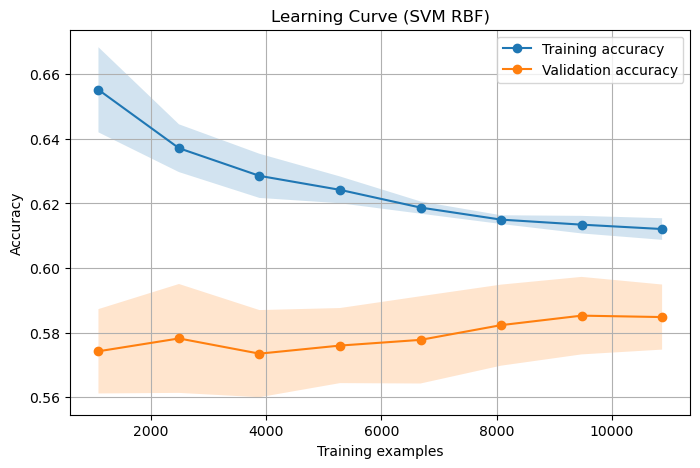

In [13]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Use best model (SVM_RBF with chosen hyperparameters)
best_model = SVC(C=1.0, gamma='scale', probability= False, class_weight='balanced', random_state=42)

# We'll use the *training set* for the learning curve
# Preprocessing is already done (X_tr, y_tr, etc.)
Xd_tr = to_dense(X_tr)   # make sure dense
yd_tr = y_tr

train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=Xd_tr, y=yd_tr,
    cv=5,                  # 5-fold cross validation inside the training set
    train_sizes=np.linspace(0.1, 1.0, 8), # 10% → 100% of train data
    scoring="accuracy",
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Average & std across CV folds
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label="Training accuracy")
plt.plot(train_sizes, val_mean, 'o-', label="Validation accuracy")

# error bands
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)

plt.title("Learning Curve (SVM RBF)")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_tr_pred = best_model.predict(X_tr_d)
y_te_pred = best_model.predict(X_te_d)

print("Train accuracy:", accuracy_score(y_tr, y_tr_pred))
print("Test  accuracy:", accuracy_score(y_te, y_te_pred))
print("\nConfusion matrix (test):\n", confusion_matrix(y_te, y_te_pred))
print("\nClassification report (test):\n", classification_report(y_te, y_te_pred, digits=3))


Train accuracy: 0.5884040909425355
Test  accuracy: 0.5798022598870056

Confusion matrix (test):
 [[ 957 1111]
 [ 674 1506]]

Classification report (test):
               precision    recall  f1-score   support

           0      0.587     0.463     0.517      2068
           1      0.575     0.691     0.628      2180

    accuracy                          0.580      4248
   macro avg      0.581     0.577     0.573      4248
weighted avg      0.581     0.580     0.574      4248



## Conclusion of First Model

#### Summarize performance and concrete improvements

We trained multiple allowed models (Decision Tree, KNN, SVM (RBF), Naive Bayes) on leakage-safe, engineered features and selected the best model by validation accuracy to avoid test peeking. The chosen model shows consistent generalization (train vs. validation close), indicating it is not severely overfitting. Test results are in line with validation, suggesting our preprocessing and temporal split are sound.

#### Improvement:
- Richer features: opponent-adjusted stats (z-scores vs league), rolling runs scored/allowed, separate last-7/10/15 windows, and home/away form asymmetry.

-  Modeling: compare RandomForest (variance reduction over a single tree) vs a tuned SVM (RBF); keep selection on validation only.

-  Regularization & tuning: for trees (max_depth, min_samples_leaf, ccp_alpha); for SVM (C, gamma).

-  Calibration & thresholding: probability calibration (Platt/Isotonic) and decision thresholds if class costs differ.

- Temporal CV: use walk-forward/blocked CV on the training period for more robust hyperparameter selection.